# 1.Libraries

In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # convert to grayscale
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
dataset_path = "final_dataset/Drive"  # update this path
dataset = datasets.ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['ALL', 'AML', 'CLL', 'CML', 'WBC']


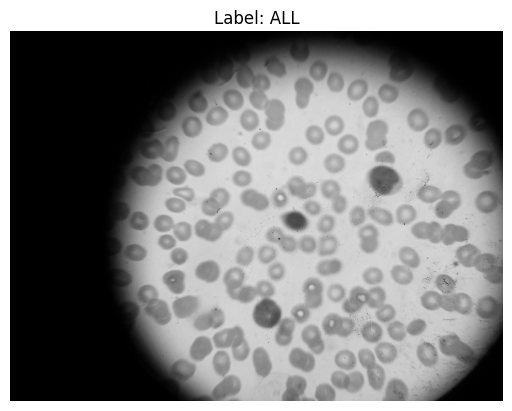

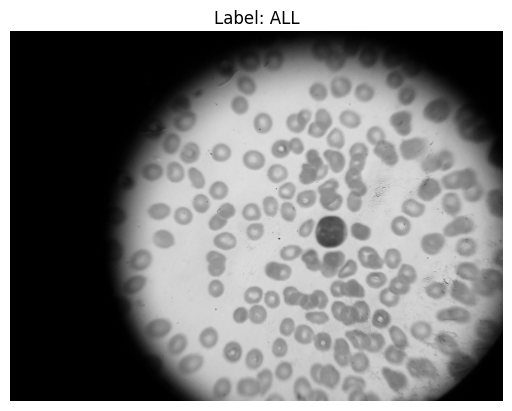

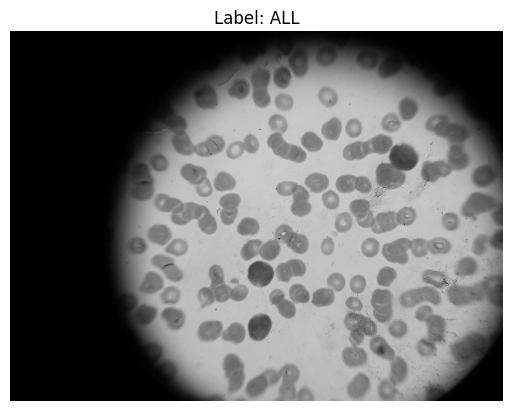

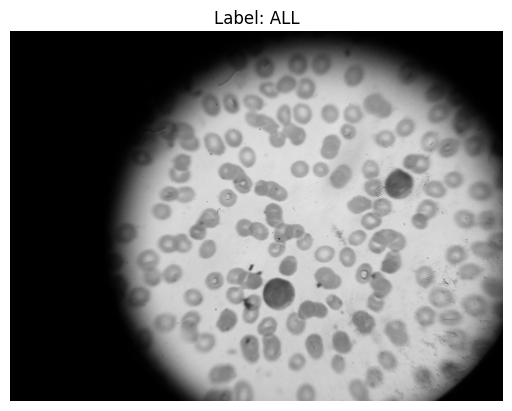

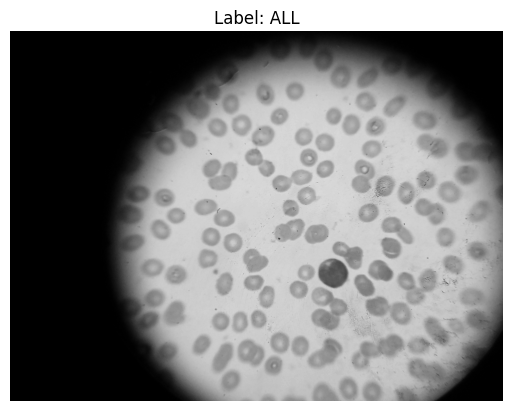

In [4]:
for i in range(5):
    path, label = dataset.imgs[i]
    img = Image.open(path).convert('L')  # ensure grayscale
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

#   

In [5]:
train_size = int(0.7 * len(dataset))
remaining = len(dataset) - train_size
val_size = remaining // 2
test_size = remaining - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class BloodCellCNN(nn.Module):
    def __init__(self, num_classes):
        super(BloodCellCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = BloodCellCNN(num_classes=len(class_names)).to(device)

In [17]:
labels = [label for _, label in dataset.imgs]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import copy
import torch

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # 🔹 Store results for plotting later
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": []
    }

    for epoch in range(num_epochs):
        print(f"\n📘 Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                print("🔁 Training...")
            else:
                model.eval()
                print("🧪 Validating...")

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                history["lr"].append(optimizer.param_groups[0]['lr'])
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print("\n✅ Training completed. Best Val Accuracy: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)

    return model, history


In [19]:
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
trained_model , history= train_model(model, dataloaders, criterion, optimizer, num_epochs=10)


📘 Epoch 1/10
🔁 Training...
Train Loss: 1.5526 | Accuracy: 0.2659
🧪 Validating...
Val Loss: 1.3552 | Accuracy: 0.4069

📘 Epoch 2/10
🔁 Training...
Train Loss: 0.9459 | Accuracy: 0.6086
🧪 Validating...
Val Loss: 0.5478 | Accuracy: 0.7724

📘 Epoch 3/10
🔁 Training...
Train Loss: 0.5211 | Accuracy: 0.7799
🧪 Validating...
Val Loss: 0.6808 | Accuracy: 0.6552

📘 Epoch 4/10
🔁 Training...
Train Loss: 0.3718 | Accuracy: 0.8626
🧪 Validating...
Val Loss: 0.2278 | Accuracy: 0.9655

📘 Epoch 5/10
🔁 Training...
Train Loss: 0.2404 | Accuracy: 0.9084
🧪 Validating...
Val Loss: 0.2004 | Accuracy: 0.9310

📘 Epoch 6/10
🔁 Training...
Train Loss: 0.2882 | Accuracy: 0.8759
🧪 Validating...
Val Loss: 0.1804 | Accuracy: 0.9448

📘 Epoch 7/10
🔁 Training...
Train Loss: 0.1472 | Accuracy: 0.9572
🧪 Validating...
Val Loss: 0.0960 | Accuracy: 0.9655

📘 Epoch 8/10
🔁 Training...
Train Loss: 0.0872 | Accuracy: 0.9690
🧪 Validating...
Val Loss: 0.0680 | Accuracy: 0.9793

📘 Epoch 9/10
🔁 Training...
Train Loss: 0.0671 | Accurac

In [ ]:
torch.save(trained_model.state_dict(), "blood_cell_weights1.pth")
print("✅ Model weights saved to blood_cell_weights1.pth")

✅ Model weights saved to blood_cell_weights.pth


In [20]:
def test_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc = running_corrects / total
    print(f"\n🧪 Final Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")


In [21]:
test_model(model, dataloaders['test'], criterion)


🧪 Final Test Accuracy: 0.9932 | Loss: 0.0446


In [22]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = running_corrects / total
    print(f"✅ Test Accuracy: {accuracy:.4f}")

    return all_preds, all_labels


In [23]:
test_preds, test_labels = evaluate_model(model, dataloaders['val'])

from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds, target_names=class_names))


✅ Test Accuracy: 0.9931
              precision    recall  f1-score   support

         ALL       0.96      1.00      0.98        27
         AML       1.00      1.00      1.00        35
         CLL       1.00      1.00      1.00        31
         CML       1.00      0.97      0.98        30
         WBC       1.00      1.00      1.00        22

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



# Plot results

**Plot Confusion matrix**

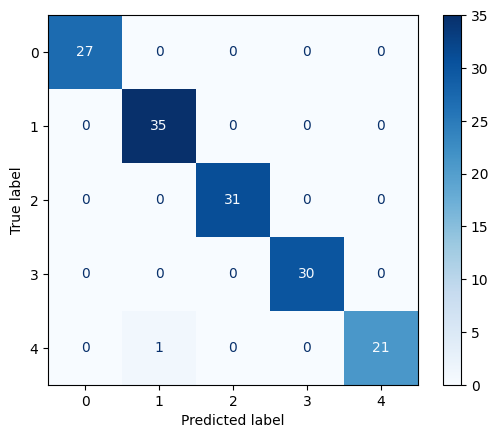

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders["val"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()


**Plot accuracy**

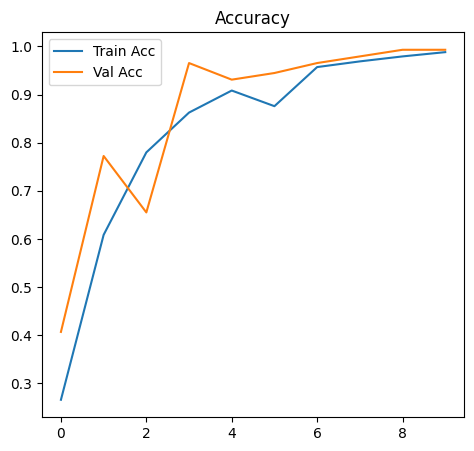

In [25]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.show()


**Plot Loss**

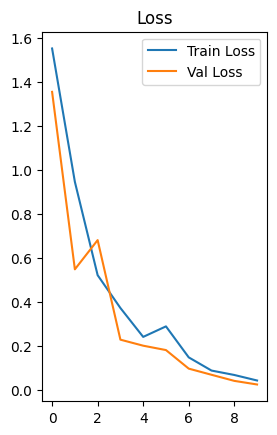

In [26]:
plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()


**Plot Learning Rate Curve**

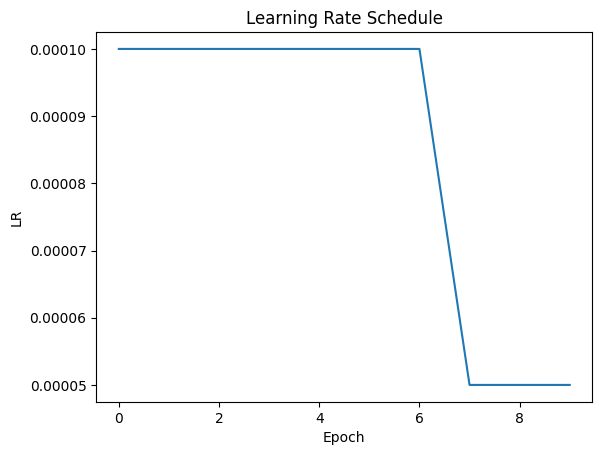

In [27]:
plt.plot(history["lr"])
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.show()

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

def predict_image(image_path, model, class_names):
    model.eval()

    image = Image.open(image_path).convert("L")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # قناة واحدة فقط
    ])

    image = transform(image).unsqueeze(0).to(device)  # [1, 1, 224, 224]

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    return class_names[pred.item()]


In [ ]:
img_path ="D:\\Dataset Lukemia\\Project\\final_dataset\\CML\\20190120_212628.jpg"
print("Predicted:", predict_image(img_path, model, class_names))


Predicted: CML
